In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


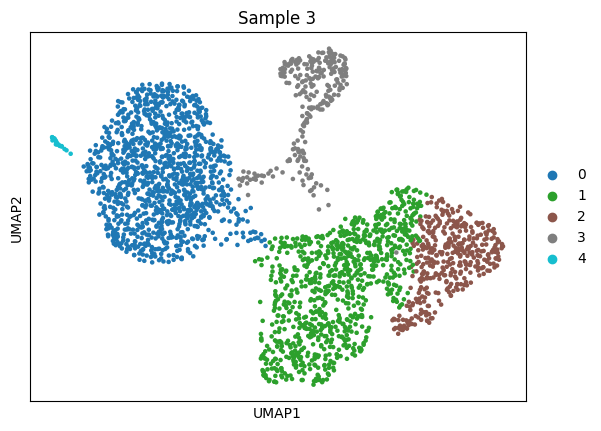

In [5]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [6]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB withou

In [7]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,dispersion_step1_sct,mean,std,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,0.101964,-4.293682,0.473112,0.012931,0.017074,-0.004143,nb,0.012927,0.031389,0.0
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,NaN,-2.245714,0.625123,0.065733,0.077217,-0.011484,nb,0.065737,0.358580,0.0
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,0.069086,-4.994343,0.371819,0.006106,0.007506,-0.001399,nb,0.006101,0.022522,0.0
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,0.020054,-1.395484,0.528697,0.108118,0.117262,-0.009144,nb,0.108118,1.176949,0.0
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,NaN,-1.124802,0.462729,0.133980,0.173501,-0.039521,nb,0.133983,0.451536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,NaN,-2.879180,0.605192,0.042026,0.048162,-0.006136,nb,0.042036,0.251568,0.0
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,0.069545,-4.231052,0.458007,0.013649,0.017773,-0.004124,nb,0.013660,0.044729,0.0
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,0.106674,-4.102461,0.514669,0.015805,0.022020,-0.006216,nb,0.015804,0.034633,0.0
zur,Gene Expression,PA01,66,0.024784,0.024482,97.629310,69.0,4.248495,66,0.026325,...,0.017477,-3.525239,0.545177,0.024784,0.026325,-0.001541,nb,0.024793,0.375156,0.0


## Find optimal correlation matrix scaling and generate synthetic null data

In [8]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 60.95578147353862
Factor: 2 - Error: 41.612303661381304
Factor: 3.6180339999999998 - Error: 47.563999700049905
Factor: 2 - Error: 41.612303661381304
Factor: 2.61803399102434 - Error: 42.672791120450384
Factor: 1.61803399 - Error: 41.928188645382356
Factor: 2.236067977595943 - Error: 41.5709760988543
Factor: 2.3819660117007944 - Error: 42.031194521158255
Factor: 2.1458980341048512 - Error: 41.553153060038696
Factor: 2.0901699441509773 - Error: 41.50337615883044
Factor: 2.055728090361706 - Error: 41.58788587302458
Factor: 2.11145618031558 - Error: 41.75948639462143
Factor: 2.077014326682086 - Error: 41.633964141952724
Factor: 2.0983005628466884 - Error: 41.84690304984847
Factor: 2.085144945437299 - Error: 41.685404726106015
Factor: 2.0932755641330094 - Error: 41.53792009143197
Factor: 2.0882505654420584 - Error: 41.40961663161147
Factor: 2.087064324160264 - Error: 41.46160031827932
Factor: 2.088983702869183 - Error: 41.47964603087207
Factor: 2.0877974615927544 - Error:

In [9]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [10]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [11]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [12]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

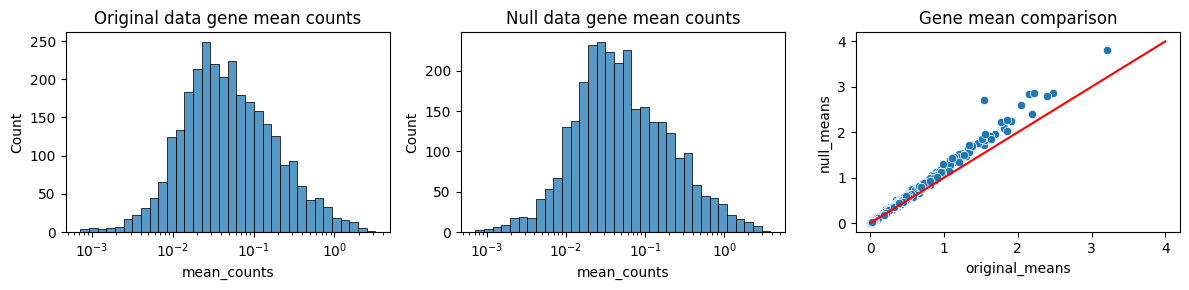

SignificanceResult(statistic=0.9949736468305259, pvalue=0.0)


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

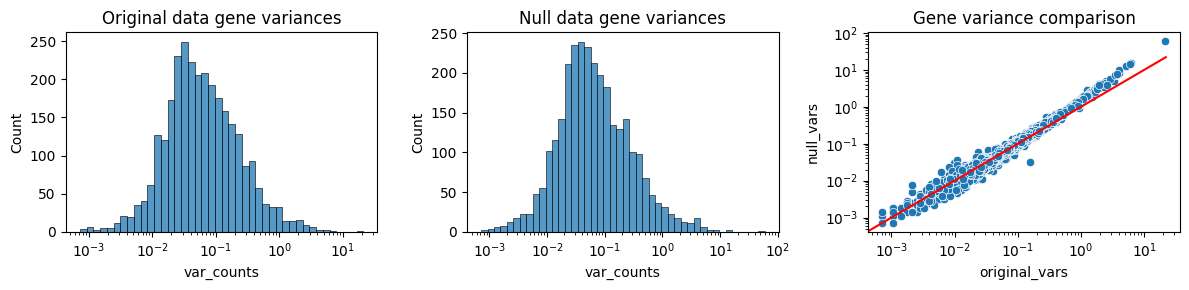

SignificanceResult(statistic=0.9894122149448698, pvalue=0.0)
[[1.         0.97716773]
 [0.97716773 1.        ]]


In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

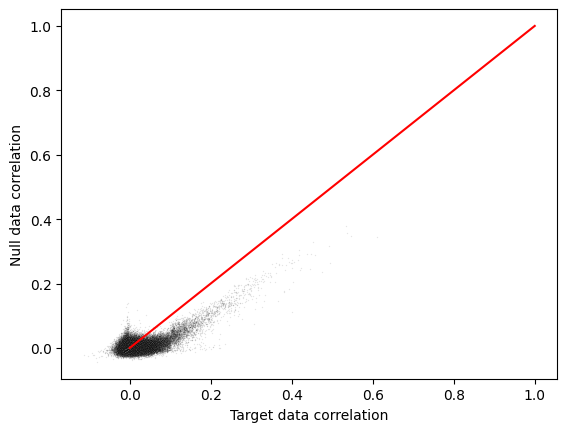

In [15]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [16]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [17]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


20


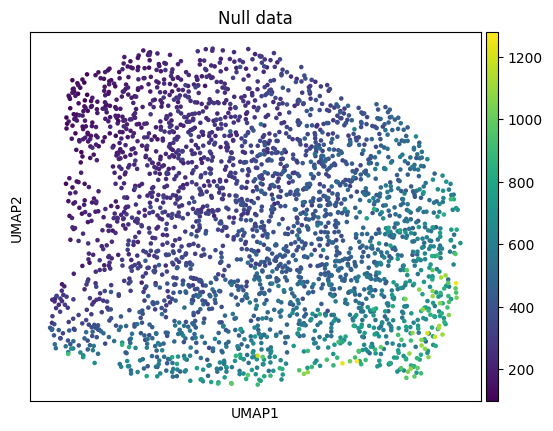

In [18]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [19]:
data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [20]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
Resolution for two clusters: 0.1


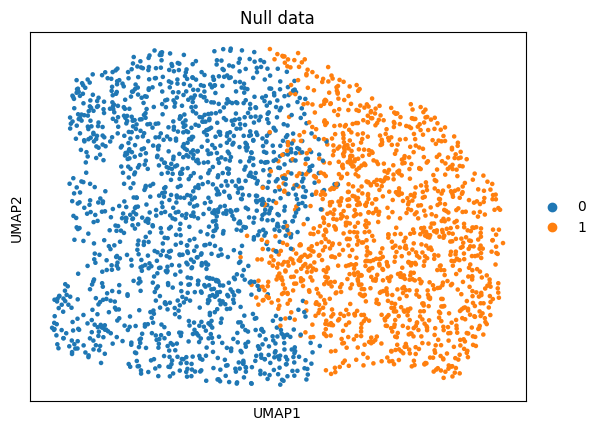

In [21]:
sc.pl.umap(data_null_gen, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [22]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [23]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [24]:
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.05307855626326964
Cluster 2 - DE genes: 0; Minimum q value: 0.44155844155844154
Cluster 3 - DE genes: 0; Minimum q value: 0.16666666666666666
Cluster 1 - DE genes: 0; Minimum q value: 0.18031430934656742
Cluster 4 - DE genes: 0; Minimum q value: 1.0


In [25]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 1192; Minimum q value: 0.00906344410876133
Cluster 2 - DE genes: 0; Minimum q value: 0.1076923076923077
Cluster 3 - DE genes: 0; Minimum q value: 0.9471228615863142
Cluster 1 - DE genes: 0; Minimum q value: 0.06318082788671024
Cluster 4 - DE genes: 0; Minimum q value: 0.5


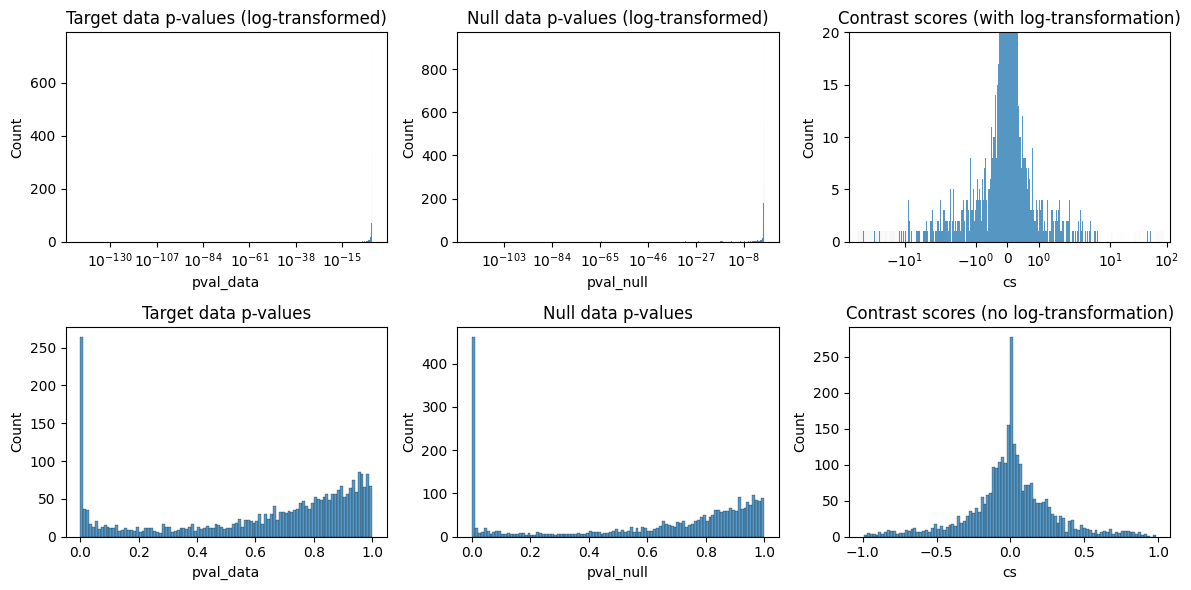

In [30]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog",
            ylim=(0, 20)
            )

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [27]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.053079    1413
0.053333      12
0.053608      30
0.053691      35
0.053892      13
            ... 
0.197149       1
0.197395       2
0.197641       2
0.198213       3
1.000000     487
Name: q, Length: 253, dtype: int64

cluster 2
0.441558    1001
0.442703      20
0.442815       2
0.443359       1
0.443470       2
            ... 
0.609863       7
0.610077       1
0.610383       4
0.610595       1
1.000000    1118
Name: q, Length: 182, dtype: int64

cluster 3
0.166667       6
0.200000       4
0.272727       1
0.307692       2
0.357143       1
0.421053       5
0.500000       1
0.608696       3
0.666667       1
0.800000       1
1.000000    2924
Name: q, dtype: int64

cluster 1
0.180314    1209
0.180395       5
0.180772       3
0.181148       3
0.181818       1
            ... 
0.340805       1
0.342779       2
0.344906       1
0.345205       1
1.000000     759
Name: q, Length: 264, dtype: int64

cluster 4
1.0    2949
Name: q, dtype: int64



In [29]:
pvals_log_gen[("1")]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
dhbB,7.139625e-105,3.930589e-55,104.146325,54.405542,49.740782,0.180314
ilvH,1.020285e-80,1.239890e-32,79.991279,31.906617,48.084662,0.180314
leuB,4.844627e-72,3.328560e-24,71.314740,23.477744,47.836996,0.180314
dhbC,3.987993e-88,4.196644e-41,87.399246,40.377098,47.022148,0.180314
dhbE,1.522584e-105,1.879997e-59,104.817419,58.725843,46.091576,0.180314
...,...,...,...,...,...,...
rplE,8.771936e-21,6.826437e-81,20.056905,80.165806,-60.108901,1.000000
rpsC,1.980698e-13,7.106902e-75,12.703182,74.148320,-61.445138,1.000000
rpsH,5.658004e-21,2.558243e-83,20.247337,82.592058,-62.344721,1.000000
fusA,8.345142e-18,1.113015e-82,17.078566,81.953499,-64.874933,1.000000
